In [4]:
import os
import glob
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import cm
from pingouin import partial_corr
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

## Compare responses in cerebellum and cortex (no features)

In [9]:
regions = {
    'fROI1_Right_CrusII_VIIb' : 'cereb_reduced_wb_10_10',
    'fROI2_Right_CrusI_Dentate' : 'cereb_reduced_wb_10_10',
    'fROI3_Right_VIIIa' : 'cereb_reduced_wb_10_10',
    'fROI4_Right_CrusI' : 'cereb_reduced_wb_10_10'
}

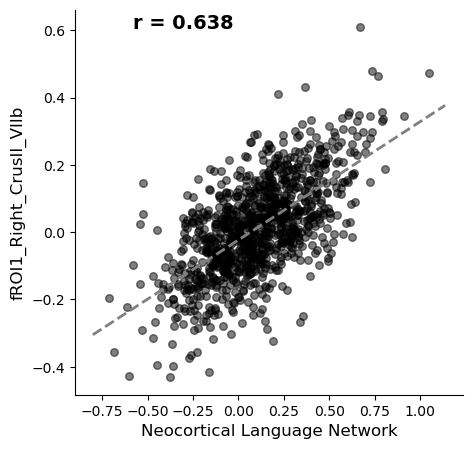

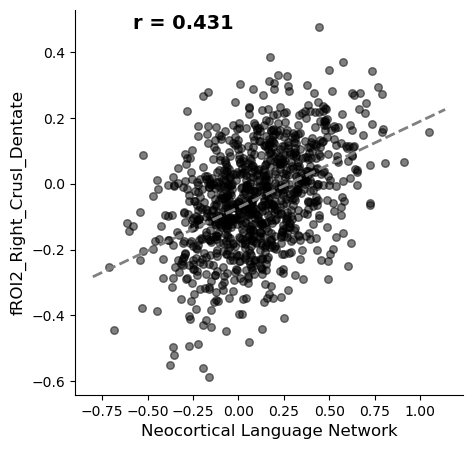

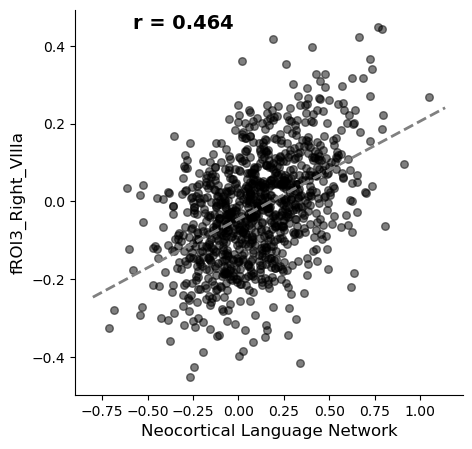

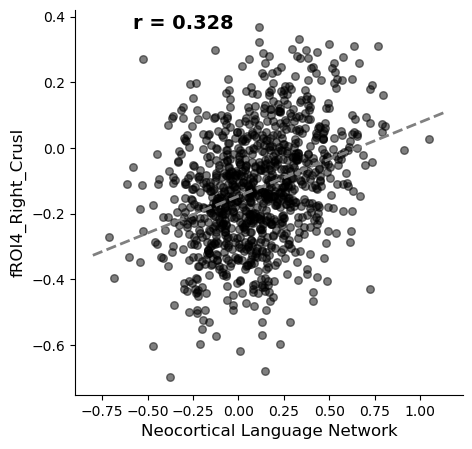

In [10]:
for region in regions.keys():
    # load data
    x = pd.read_csv('data_combined/language.csv').average.values
    y = pd.read_csv('data_combined/'+region+'.csv').average.values

    # plot correlation of surprisal and socialness
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    plt.rc('font',**{'family':'sans-serif'})
    plt.rc('pdf', **{'fonttype':42})
    fig,ax = plt.subplots(figsize=(5,5))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    ax.scatter(x,y,s=30,c='k',alpha=0.5,zorder=1)
                            
    # dashed fit line
    slope, intercept, r, p, _ = scipy.stats.linregress(x,y)
    f = lambda a : slope*a + intercept
    xlim = ax.get_xlim()
    xvals = np.arange(xlim[0],xlim[1],0.001)
    yvals = f(xvals)
    ax.plot(xvals,yvals,'--',color='grey',linewidth=2,zorder=2)
    
    sig_label1 = 'r = ' + str(round(r,3))
    ax.annotate(text=sig_label1, xy =(0.15,0.95), xycoords='axes fraction', fontsize=14, weight="heavy")
    
    ax.set_xlabel('Neocortical Language Network',fontsize=12)
    ax.set_ylabel(region,fontsize=12)
    
    # save
    plt.savefig(f'plots/language_vs_{region}.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5) 
    plt.savefig(f'plots/language_vs_{region}.png',format='png',bbox_inches='tight',pad_inches=0.5) 

In [ ]:
# compute the noise ceiling by region! 
regions = [
    'fROI1_Right_CrusII_VIIb',
    'fROI2_Right_CrusI_Dentate',
    'fROI3_Right_VIIIa',
    'fROI4_Right_CrusI'
]
output_within = pd.DataFrame()
output_between = pd.DataFrame()

# take correlations across subs **within lang**
lang = pd.read_csv('data_combined/language.csv')
subs = lang.columns[2:7].tolist()
lang_corrs = np.triu(lang.loc[:,subs].corr().values,1).flatten()
lang_corrs = lang_corrs[np.nonzero(lang_corrs)]
output_within['language'] = lang_corrs

# iterate over regions
for region in regions:
    output_curr = pd.DataFrame()
    data = pd.read_csv('data_combined/'+region+'.csv')

    # take correlations across subs **within cereb region**
    cereb_corrs = np.triu(data.loc[:,subs].corr().values,1).flatten()
    cereb_corrs = cereb_corrs[np.nonzero(cereb_corrs)]

    # take correlations across subs **between cereb and lang**
    between_corrs = pd.concat([lang.loc[:,subs], data.loc[:,subs]], axis=1).corr().values[:5,5:]
    np.fill_diagonal(between_corrs, 0)
    between_corrs = between_corrs.flatten()
    between_corrs = between_corrs[np.nonzero(between_corrs)]
    
    output_within[region] = cereb_corrs
    output_between['language_vs_'+region] = between_corrs

output_within.to_csv('noise_ceilings_by_region_within.csv', index=False)
output_between.to_csv('noise_ceilings_by_region_between.csv', index=False)

In [30]:
output_within.mean(axis=0)

language                     0.069838
fROI1_Right_CrusII_VIIb      0.036014
fROI2_Right_CrusI_Dentate    0.027709
fROI3_Right_VIIIa            0.031729
fROI4_Right_CrusI            0.010012
dtype: float64

In [31]:
output_between.mean(axis=0)

language_vs_fROI1_Right_CrusII_VIIb      0.044729
language_vs_fROI2_Right_CrusI_Dentate    0.031535
language_vs_fROI3_Right_VIIIa            0.045195
language_vs_fROI4_Right_CrusI            0.026124
dtype: float64

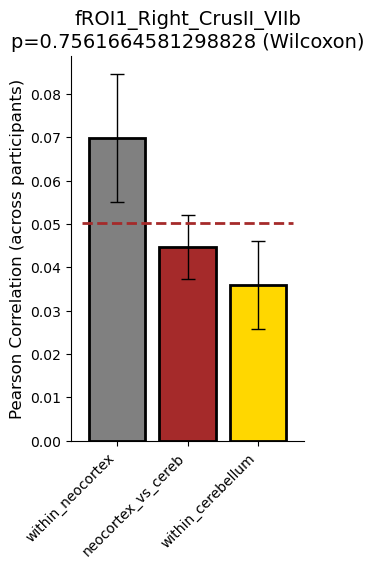

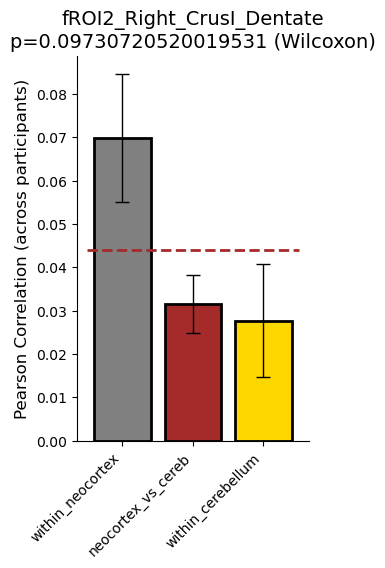

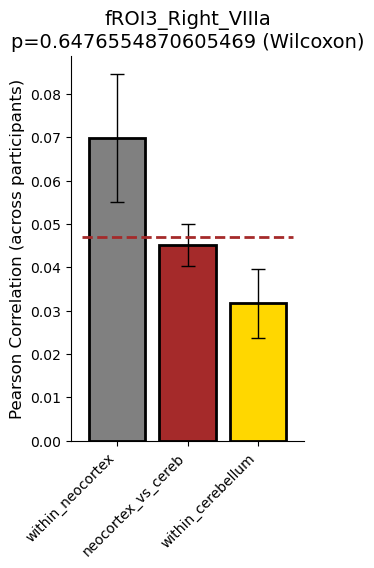

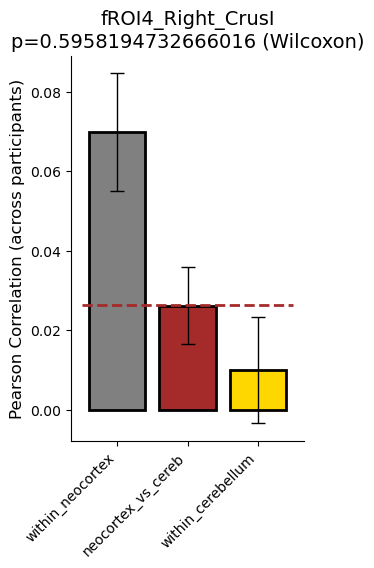

In [47]:
# plot
within = pd.read_csv('noise_ceilings_by_region_within.csv')
between = pd.read_csv('noise_ceilings_by_region_between.csv')

regions = [
    'fROI1_Right_CrusII_VIIb',
    'fROI2_Right_CrusI_Dentate',
    'fROI3_Right_VIIIa',
    'fROI4_Right_CrusI'
]

# separate plot per region
for region in regions:

    # plot
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    plt.rc('font',**{'family':'sans-serif'})
    plt.rc('pdf', **{'fonttype':42})
    fig,ax = plt.subplots(figsize=(3,5))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    labels = ['within_neocortex','neocortex_vs_cereb','within_cerebellum']
    colors = ['grey','brown','gold']
    
    xs = np.arange(1,4)
    ys = [
        within.language.mean(axis=0),
        between['language_vs_'+region].mean(axis=0),
        within[region].mean(axis=0)
    ]
    yerrs = [
        within.language.std(axis=0) / np.sqrt(within.shape[0]),
        between['language_vs_'+region].std(axis=0) / np.sqrt(between.shape[0]),
        within[region].std(axis=0) / np.sqrt(within.shape[0])
    ]
    
    plt.bar(
        x=xs,
        height=ys,
        yerr=yerrs,
        color=colors,
        edgecolor='k',
        linewidth=2,
        capsize=5,
        error_kw={'elinewidth' : 1, 'capthick' : 1}
    )

    geom_mean = np.sqrt(ys[0]*ys[2])
    plt.plot([0.5,3.5],[geom_mean,geom_mean],'--',color='brown',linewidth=2)

    # test significance
    diffs = between['language_vs_'+region].values - geom_mean
    stat, pval = scipy.stats.wilcoxon(diffs)
    
    # plt.scatter(
    #         [x]*y.shape[0],
    #         y,
    #         s=np.array([100]*y.shape[0]),
    #         c=[color]*y.shape[0],
    #         edgecolors='k',
    #         alpha=0.3)

    ax.set_xticks(xs)
    ax.set_xticklabels(labels, ha='right', rotation=45, fontsize=10)
    ax.set_ylabel('Pearson Correlation (across participants)',fontsize=12)
    ax.set_title(f'{region}\np={pval} (Wilcoxon)', fontsize=14)

    # save
    plt.savefig(f'plots/language_vs_{region}_noise_ceilings.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5) 
    plt.savefig(f'plots/language_vs_{region}_noise_ceilings.png',format='png',bbox_inches='tight',pad_inches=0.5) 

## Implement partial correlations 

In [10]:
# --- REPEAT ONLY WITH PROCCESING DIFFICULTY FEATURES ---
features = [
    'surprisal-5gram_mean',
    'surprisal-gpt2-xl_mean',
    'surprisal-pcfg_mean',
    'rating_gram_mean',
    'rating_sense_mean',
    'rating_frequency_mean',
    'rating_conversational_mean'
]
regions = [
    'language',
    'fROI1_Right_CrusII_VIIb',
    'fROI2_Right_CrusI_Dentate',
    'fROI3_Right_VIIIa',
    'fROI4_Right_CrusI'
]

In [11]:
# load and standardize features
features_FULL = pd.read_csv('../from_greta/beta-control-neural_stimset_D-S_light_compiled-feats-n=18.csv')
features_FULL = features_FULL.loc[features_FULL.item_id<=1000]
features_unit = features_FULL.loc[:,['item_id','sentence']]
for feature in features:
    vec = features_FULL.loc[:,feature]
    features_unit[feature] = (vec - vec.mean()) / vec.std()

# add neural data
for region in regions:
    features_unit[region] = pd.read_csv(f'data_combined/{region}.csv').average.values

data = features_unit

/tmp/ipykernel_2112530/1324597593.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', len(features))
/tmp/ipykernel_2112530/1324597593.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', len(features))
/tmp/ipykernel_2112530/1324597593.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', len(features))
/tmp/ipykernel_2112530/1324597593.py:25: MatplotlibDeprecationWarning: The g

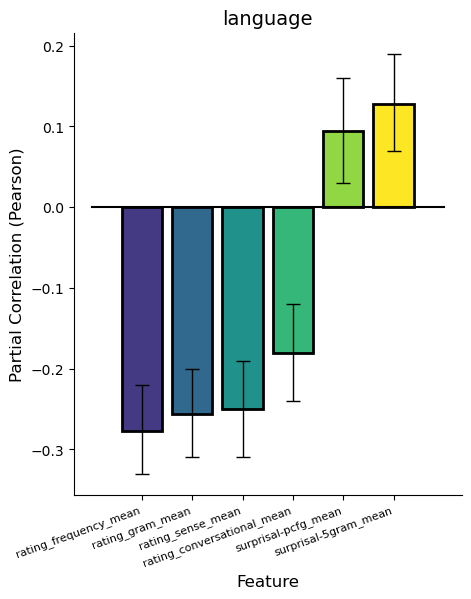

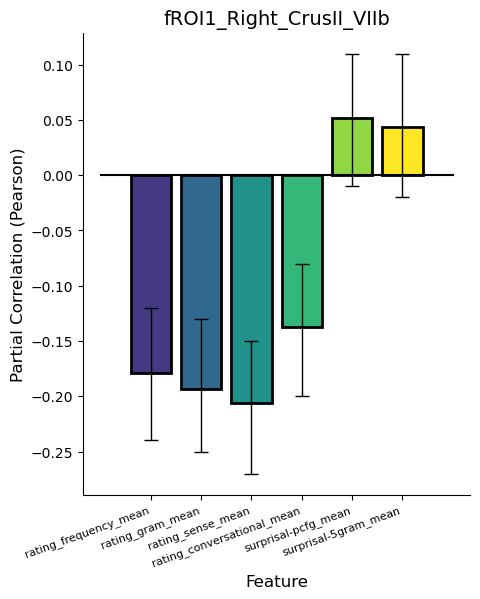

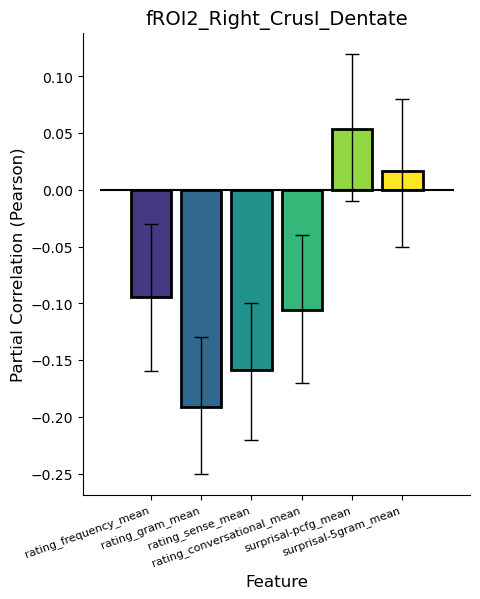

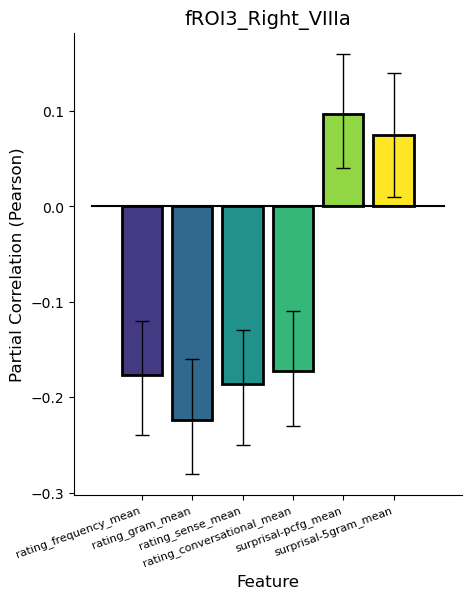

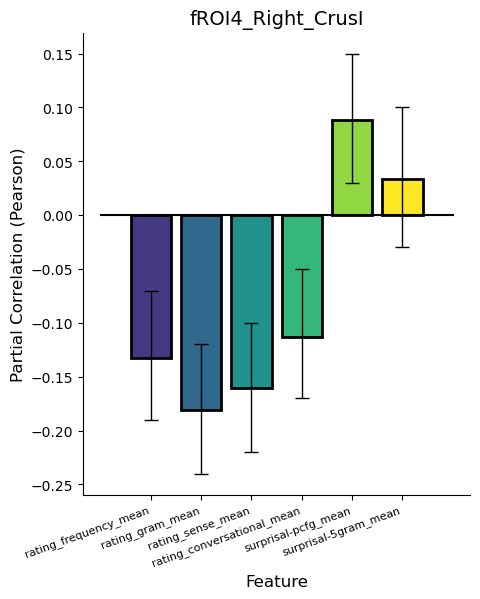

In [13]:
for region in regions:

    output = pd.DataFrame()

    for feat in features:
        if feat=='surprisal-gpt2-xl_mean':
            continue
        covar = ['surprisal-gpt2-xl_mean']
        stats = partial_corr(data=data, x=feat, y=region, covar=covar)
        stats.index = [feat]
        output = pd.concat([output,stats], axis=0)

    output.round(4).to_csv(f'partial_correlations_{region}.csv',index=True)

    if region=='language':
        sorted_idxs = np.argsort(output.r.values)
        
    # plot
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    plt.rc('font',**{'family':'sans-serif'})
    plt.rc('pdf', **{'fonttype':42})
    fig,ax = plt.subplots(figsize=(5,6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    viridis = cm.get_cmap('viridis', len(features))

    CIs = np.vstack(output['CI95%'].values).T
    CIs[0,:] = output.r.values.T-CIs[0,:]
    CIs[1,:] = CIs[1,:]-output.r.values.T
    
    plt.bar(
        x=np.arange(1,len(features)),
        height=output.r.values[sorted_idxs],
        yerr=CIs[:,sorted_idxs],
        edgecolor='k',
        linewidth=2,
        color=viridis(np.arange(1,len(features))),
        capsize=5,
        error_kw={'elinewidth' : 1, 'capthick' : 1}
    )

    plt.plot([0,len(features)],[0,0],'k')
    ax.set_xticks(np.arange(1,len(features)))
    ax.set_xticklabels(np.array([features[0]]+features[2:])[sorted_idxs], ha='right', rotation=20, fontsize=8)
    ax.set_xlabel('Feature',fontsize=12)
    ax.set_ylabel('Partial Correlation (Pearson)',fontsize=12)
    ax.set_title(region, fontsize=14)
    
    # save
    plt.savefig(f'plots/partial_correlations_{region}_over_surprisal-gpt2-xl_mean_processing_difficulty_only.pdf',format='pdf',bbox_inches='tight',pad_inches=0.5) 
    plt.savefig(f'plots/partial_correlations_{region}_over_surprisal-gpt2-xl_mean_processing_difficulty_only.png',format='png',bbox_inches='tight',pad_inches=0.5) 
        